In [1]:
import cv2
import numpy as np
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
from icecream import ic
%matplotlib inline

image_path = 'inputs/173.png'

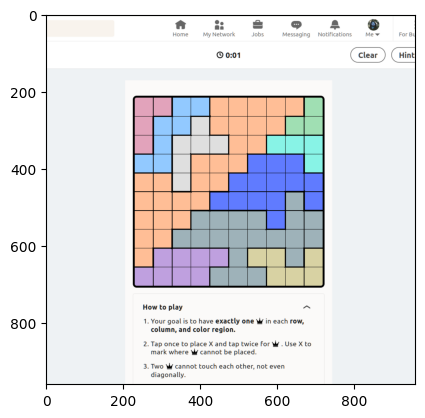

In [2]:
image = cv2.imread(image_path)
# show image
plt.imshow(image)
plt.show()

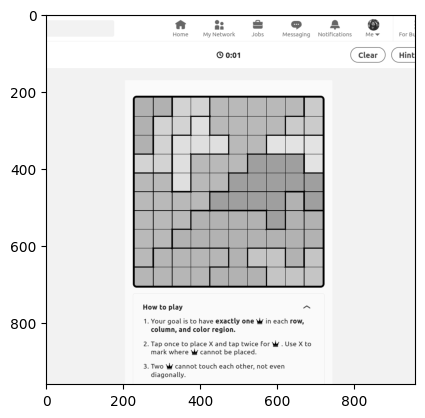

In [3]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap='gray')


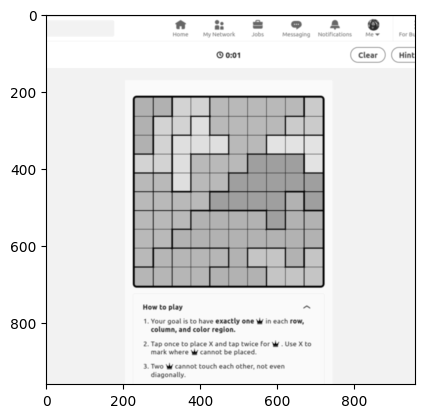

In [4]:
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
plt.imshow(blurred, cmap='gray')

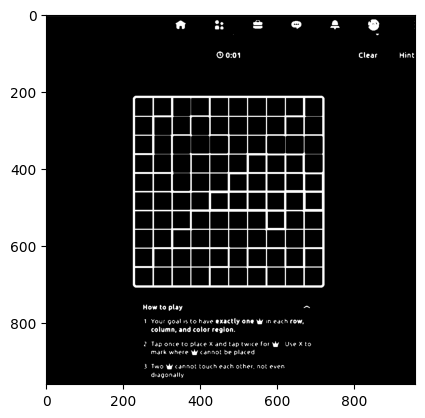

In [5]:
_, thresh = cv2.threshold(blurred, 150, 255, cv2.THRESH_BINARY_INV)
plt.imshow(thresh, cmap='gray')

Total number of contours found:  208


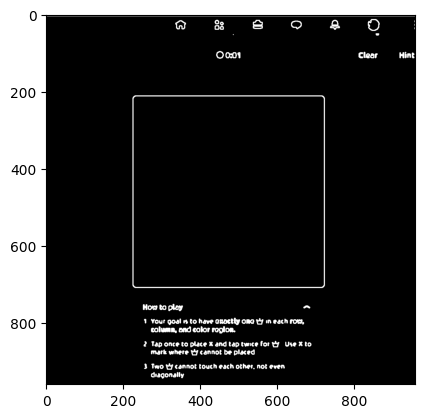

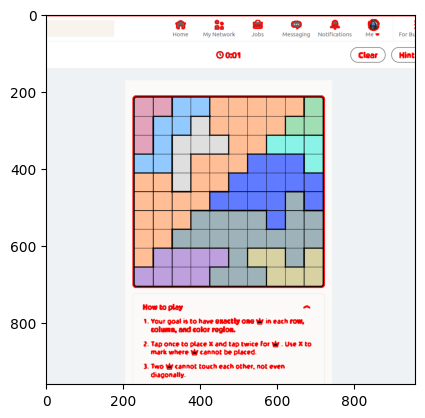

In [6]:
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
print("Total number of contours found: ", len(contours))
# visualize contours on black image
contour_image = np.zeros_like(gray)
cv2.drawContours(contour_image, contours, -1, (255, 255, 255), 2)
plt.imshow(contour_image, cmap='gray')
plt.show()

# visualize contours on original image
contour_image = np.copy(image)
cv2.drawContours(contour_image, contours, -1, (255, 0, 0), 2)
plt.imshow(contour_image)
plt.show()


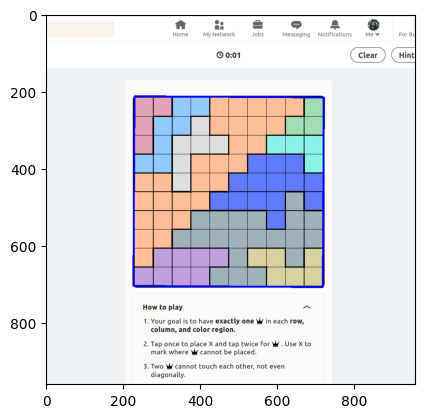

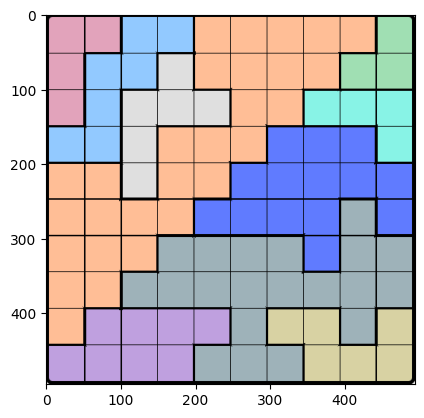

ic| grid_image.shape: (496, 495, 3)


(496, 495, 3)

In [7]:
# Find the contour that looks like the largest square (the grid)
largest_square_contour = None
max_area = 0

for contour in contours:
    # Approximate the contour to a polygon and check if it has 4 sides and 4 sides are equal in length
    approx = cv2.approxPolyDP(contour, 0.02 * cv2.arcLength(contour, True), True)
    area = cv2.contourArea(contour)
    if len(approx) == 4:
        lens = [np.linalg.norm(approx[i-1] - approx[i]) for i in range(4)]

        if max(lens) - min(lens) <= 10 and area > max_area:
            largest_square_contour = approx
            max_area = area

assert largest_square_contour is not None, 'Grid not found!'
# draw the largest square contour
largest_square_contour_image = np.copy(image)
cv2.drawContours(largest_square_contour_image, [largest_square_contour], -1, (0, 0, 255), 3)
plt.imshow(largest_square_contour_image)
plt.show()

# Get the bounding box of the grid
x, y, w, h = cv2.boundingRect(largest_square_contour)

grid_image = image[y:y+h, x:x+w]
plt.imshow(grid_image)
plt.show()
ic(grid_image.shape)

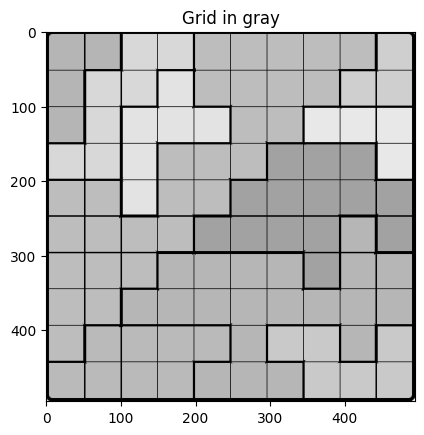

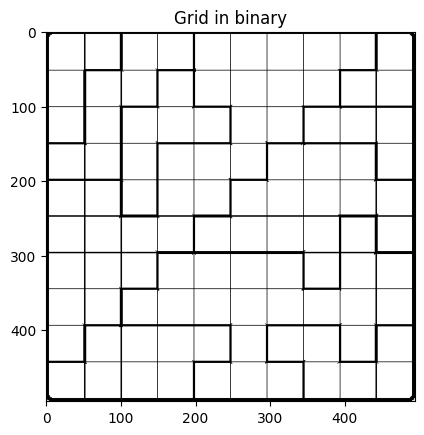

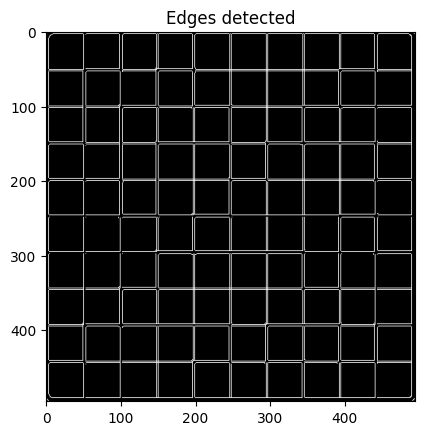

ic| horizontal_lines.shape: (29,), vertical_lines.shape: (29,)
ic| len(merged_vertical_lines): 11, len(merged_horizontal_lines): 11


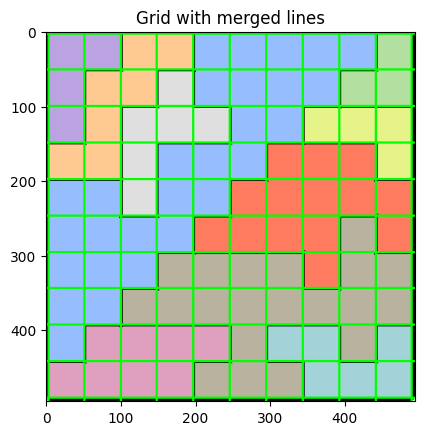

In [8]:
grid_gray = cv2.cvtColor(grid_image, cv2.COLOR_BGR2GRAY)
plt.imshow(grid_gray, cmap='gray')
plt.title("Grid in gray")
plt.show()

# convert gray to binary
_, grid_binary = cv2.threshold(grid_gray, 150, 255, cv2.THRESH_BINARY)

plt.imshow(grid_binary, cmap='gray')
plt.title("Grid in binary")
plt.show()

# Use Canny edge detection to find lines
edges = cv2.Canny(grid_binary, 50,150, apertureSize=3)

# Show the edges
plt.imshow(edges, cmap='gray')
plt.title("Edges detected")
plt.show()

# Sum pixel intensities along columns and rows to find grid lines
horizontal_sum = np.sum(edges, axis=1)
vertical_sum = np.sum(edges, axis=0)

# Find peaks in the horizontal and vertical sums
horizontal_lines = np.where(horizontal_sum > np.mean(horizontal_sum))[0]
vertical_lines = np.where(vertical_sum > np.mean(vertical_sum))[0]
ic(horizontal_lines.shape, vertical_lines.shape)

# Function to merge close lines based on a threshold
def merge_close_lines(lines, threshold):
    if len(lines) == 0:
        return lines
    merged_lines = [lines[0]]
    for i in range(1, len(lines)):
        if lines[i] - merged_lines[-1] > threshold:
            merged_lines.append(lines[i])
        else:
            merged_lines[-1] = (merged_lines[-1] + lines[i]) // 2  # Average the close lines
    return merged_lines

# Define the threshold distance to merge lines
threshold = 10

# Merge close horizontal and vertical lines
merged_horizontal_lines = merge_close_lines(horizontal_lines, threshold)
merged_vertical_lines = merge_close_lines(vertical_lines, threshold)

ic(len(merged_vertical_lines), len(merged_horizontal_lines))

assert len(merged_vertical_lines) == len(merged_horizontal_lines), "Grid is not square!"

# Visualize the merged grid lines on the original grid image
grid_with_lines = np.copy(grid_image)
h, w = grid_image.shape[:2]

for line in merged_vertical_lines:
    cv2.line(grid_with_lines, (line, 0), (line, h), (0, 255, 0), 2)
for line in merged_horizontal_lines:
    cv2.line(grid_with_lines, (0, line), (w, line), (0, 255, 0), 2)

plt.imshow(cv2.cvtColor(grid_with_lines, cv2.COLOR_BGR2RGB))
plt.title("Grid with merged lines")
plt.show()

ic| cell_colors.shape: (10, 10, 3)


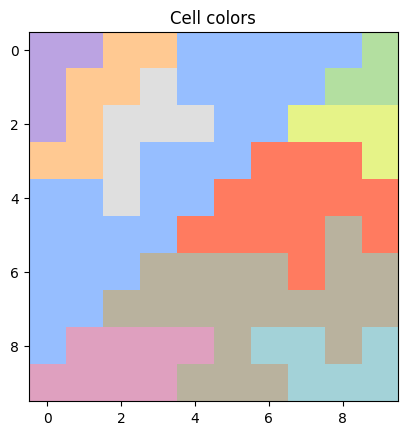

In [9]:
from collections import Counter

# Prepare to extract cell colors based on the grid lines
def get_dominant_color(cell):
    pixels = np.reshape(cell, (-1, 3))  # Flatten the cell to a list of pixels
    pixels = [tuple(pixel) for pixel in pixels]  # Convert pixels to tuples for counting
    color_count = Counter(pixels)
    dominant_color = color_count.most_common(1)[0][0]  # Most frequent color
    return dominant_color

# Create a 2D array to store the cell colors
cell_colors = np.zeros((len(merged_horizontal_lines) - 1, len(merged_vertical_lines) - 1, 3), dtype=np.uint8)

# Iterate through each cell in the grid
for i in range(len(merged_horizontal_lines) - 1):
    row_colors = []
    for j in range(len(merged_vertical_lines) - 1):
        # Extract the cell from the image using the merged grid lines
        top, bottom = merged_horizontal_lines[i], merged_horizontal_lines[i + 1]
        left, right = merged_vertical_lines[j], merged_vertical_lines[j + 1]
        cell = grid_image[top:bottom, left:right]

        # Get the dominant color of the cell
        cell_colors[i, j] = get_dominant_color(cell)


ic(cell_colors.shape)
# Visualize the cell colors
plt.imshow(cv2.cvtColor(cell_colors, cv2.COLOR_BGR2RGB))
plt.title("Cell colors")
plt.show()


ic| color_ids.shape: (10, 10), len(unique_colors): 10


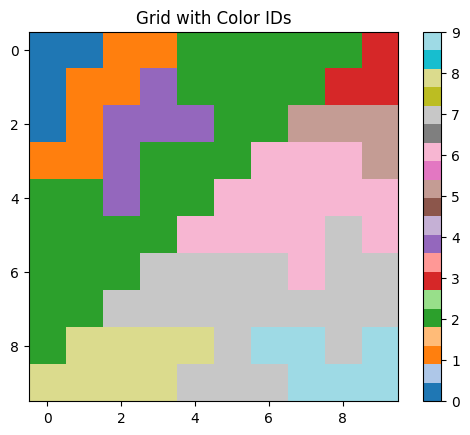

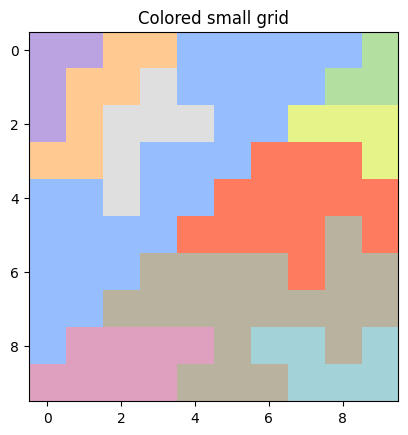

In [10]:
def color_within_tolerance(color1, color2, tolerance=5):
    """Check if two colors are within the given tolerance."""
    return all(abs(int(c1) - int(c2)) <= tolerance for c1, c2 in zip(color1, color2))

def assign_color_id(cell_colors, tolerance=5):
    """Assign a unique color ID to each cell based on fuzzy matching of colors."""
    color_ids = np.zeros((cell_colors.shape[0], cell_colors.shape[1]), dtype=int)
    unique_colors = []  # List of unique colors identified

    next_color_id = 0

    for i in range(cell_colors.shape[0]):
        for j in range(cell_colors.shape[1]):
            current_color = tuple(cell_colors[i, j])
            matched = False
            # Check if current_color matches any known unique color within the tolerance
            for idx, unique_color in enumerate(unique_colors):
                if color_within_tolerance(current_color, unique_color, tolerance):
                    color_ids[i, j] = idx
                    matched = True
                    break

            if not matched:
                # New unique color, assign a new color ID
                unique_colors.append(current_color)
                color_ids[i, j] = next_color_id
                next_color_id += 1

    return color_ids, unique_colors

# Assign color IDs to the cells based on fuzzy matching
color_ids, unique_colors = assign_color_id(cell_colors, tolerance=5)

ic(color_ids.shape, len(unique_colors))
assert color_ids.shape[0] == color_ids.shape[1] == len(unique_colors), "Grid is not square or regions is not equal to rows"

# Visualize the color IDs
plt.imshow(color_ids, cmap='tab20')  # Using 'tab20' colormap for categorical colors
plt.title("Grid with Color IDs")
plt.colorbar()
plt.show()

colored_small_grid = np.zeros((color_ids.shape[0], color_ids.shape[1], 3), dtype=np.uint8)
for i in range(color_ids.shape[0]):
    for j in range(color_ids.shape[1]):
        colored_small_grid[i, j] = unique_colors[color_ids[i, j]]

plt.imshow(cv2.cvtColor(colored_small_grid, cv2.COLOR_BGR2RGB))
plt.title("Colored small grid")
plt.show()


Solution found!
(0, 3)
(1, 8)
(2, 0)
(3, 9)
(4, 2)
(5, 5)
(6, 1)
(7, 6)
(8, 4)
(9, 7)


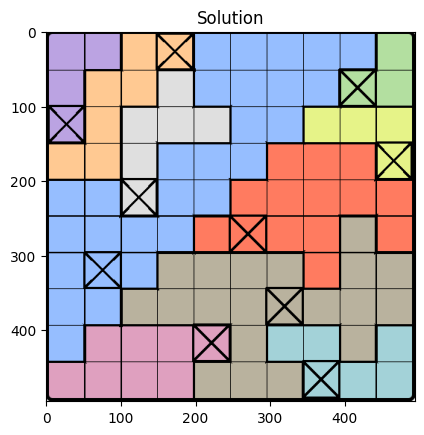

In [11]:
from ortools.sat.python import cp_model
import numpy as np

# Define the problem size (number of rows/columns)
n = color_ids.shape[0]

# Instantiate the CP-SAT model
model = cp_model.CpModel()

# Create decision variables: one boolen variable for each cell
queens = [
     [model.new_bool_var(f"cell_{row}_{col}") for col in range(n)]
        for row in range(n)
]
for row in queens:
    model.add_exactly_one(row)
for col_index in range(n):
    model.add_exactly_one([row[col_index] for row in queens])

# for each region we need to have exactly one queen
# two cell's region is same if their color is same
region_cells = {}
for i in range(n):
    for j in range(n):
        if color_ids[i,j] not in region_cells:
            region_cells[color_ids[i,j]] = []
        region_cells[color_ids[i,j]].append(queens[i][j])

for region in region_cells.values():
    model.add_exactly_one(region)

# two queens can't touch by corner
for i in range(n-1):
    for j in range(n-1):
        model.add_at_most_one([queens[i][j], queens[i+1][j+1]])

for i in range(0,n-1):
    for j in range(1,n):
        model.add_at_most_one([queens[i][j], queens[i+1][j-1]])


# Create a solver and solve the model
solver = cp_model.CpSolver()
status = solver.Solve(model)

# Output the solution if it exists
if status == cp_model.FEASIBLE or status == cp_model.OPTIMAL:
    print("Solution found!")
    for row in range(n):
        for col in range(n):
            if solver.Value(queens[row][col]):
                print(f"({row}, {col})")

    # visualize the solution
    solution = np.copy(grid_image)
    for row in range(n):
        for col in range(n):
            if solver.Value(queens[row][col]):
                top, bottom = merged_horizontal_lines[row], merged_horizontal_lines[row + 1]
                left, right = merged_vertical_lines[col], merged_vertical_lines[col + 1]
                cv2.rectangle(solution, (left, top), (right, bottom), (0, 0, 0), 2)
                # draw a cross in the cell
                cv2.line(solution, (left, top), (right, bottom), (0, 0, 0), 2)
                cv2.line(solution, (right, top), (left, bottom), (0, 0, 0), 2)


    plt.imshow(cv2.cvtColor(solution, cv2.COLOR_BGR2RGB))
    plt.title("Solution")
    plt.show()
else:
    assert False, "No solution found."
